<a href="https://colab.research.google.com/github/ThilinaTLM/document-analyzer-boundry-detection/blob/main/Document_Analyzer_Boundary_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from urllib import request

In [2]:
image_urls = [
          "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDC-2wAkbUjzQruyK_EuSkP9iAGLNJPJFw2sM4ip6DIpDRNEj9-G5lOpZ_4bDvzxNRErg&usqp=CAU",
          "https://photo-store.cvs.com/resources/images/cvs/store/2015/global/980x640/print-services-980x640.jpg",
          "https://media.gcflearnfree.org/content/569510564ba91313b031ec84_01_12_2016/place.jpg"
]

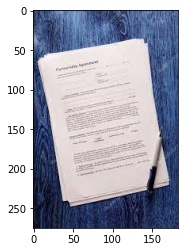

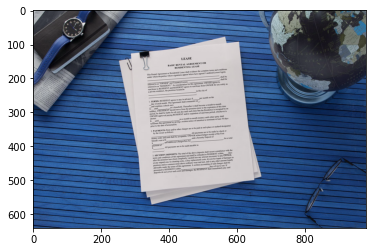

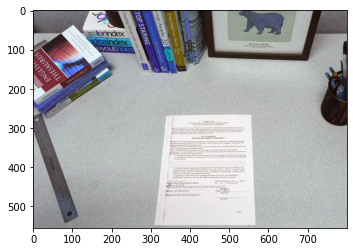

In [3]:
def get_image_from_url(url):
  req = request.urlopen(url)
  arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
  img = cv2.imdecode(arr, -1) # 'Load it as it is'
  return img

images = [get_image_from_url(url) for url in image_urls]

for img in images:
  plt.figure()
  plt.imshow(img)

In [4]:

# convert to grayscale
def apply_gray(img):
  return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# apply threshold
def apply_threshold(img):
  return cv2.threshold(img, 190, 255, cv2.THRESH_BINARY)[1]

# apply morphology
def apply_morphology(img):
  kernel = np.ones((7,7), np.uint8)
  morph = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  kernel = np.ones((9,9), np.uint8)
  morph = cv2.morphologyEx(morph, cv2.MORPH_ERODE, kernel)
  return morph

# get largest contour
def get_largest_contours(img):
  contours = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contours = contours[0] if len(contours) == 2 else contours[1]
  area_thresh = 0
  for c in contours:
      area = cv2.contourArea(c)
      if area > area_thresh:
          area_thresh = area
          big_contour = c
  return big_contour

def extract_paper_from_image(img):
  gray = apply_gray(img)
  thresh = apply_threshold(gray)
  morph = apply_morphology(thresh)

  big_contour = get_largest_contours(morph)
  # get bounding box
  x,y,w,h = cv2.boundingRect(big_contour)

  # draw filled contour on black background
  mask = np.zeros_like(gray)
  mask = cv2.merge([mask,mask,mask])
  cv2.drawContours(mask, [big_contour], -1, (255,255,255), cv2.FILLED)

  # apply mask to input
  result1 = img.copy()
  result1 = cv2.bitwise_and(result1, mask)

  # crop result
  croped_result = result1[y:y+h, x:x+w]
  return croped_result

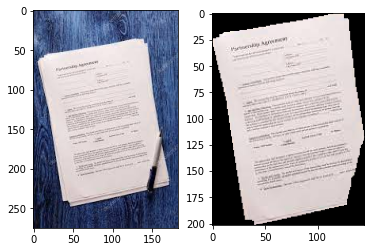

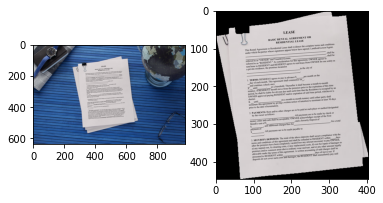

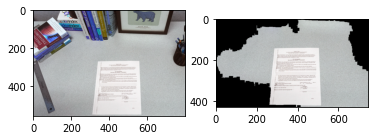

In [5]:
results = [extract_paper_from_image(img) for img in images]

for orig, res in zip(images, results):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(orig)
  plt.subplot(1, 2, 2)
  plt.imshow(res)

## Test

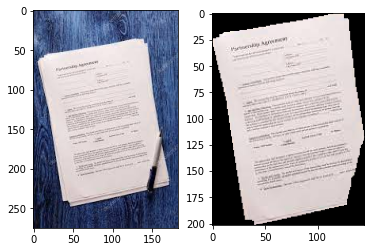

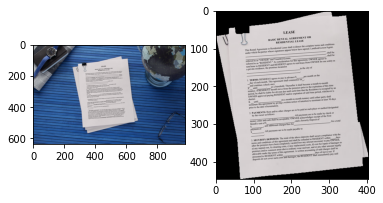

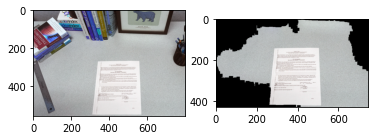

In [6]:
def test_extract_paper_from_image(img):
  gray = apply_gray(img)

  # blur = cv2.medianBlur(gray, 11)
  thresh = cv2.threshold(gray, 190, 255, cv2.THRESH_BINARY)[1]
  morph = apply_morphology(thresh)
  

  big_contour = get_largest_contours(morph)
  # get bounding box
  x,y,w,h = cv2.boundingRect(big_contour)

  # draw filled contour on black background
  mask = np.zeros_like(gray)
  mask = cv2.merge([mask,mask,mask])
  cv2.drawContours(mask, [big_contour], -1, (255,255,255), cv2.FILLED)

  # apply mask to input
  result1 = img.copy()
  result1 = cv2.bitwise_and(result1, mask)

  # crop result
  croped_result = result1[y:y+h, x:x+w]
  return croped_result

results = [test_extract_paper_from_image(img) for img in images]

for orig, res in zip(images, results):
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow(orig)
  plt.subplot(1, 2, 2)
  plt.imshow(res)